# Exercise worksheet no 2 - Marius Herrmann | uyrra@student.kit.edu | 2559255

# Linear models, the bias-variance trade-off, and the curse of dimensionality
*Machine learning in climate and environmental sciences, winter semester 2024, Jun.-Prof. Peer Nowack, peer.nowack@kit.edu*

*Chair for AI in Climate and Environmental Sciences, https://ki-klima.iti.kit.edu*

**Learning goals:** In this notebook, you will practice key concepts of machine learning model optimization, including regularization, cross-validation, and hyperparameter tuning. You will also learn more about the linear statistical learning methods called ridge and LASSO regression. 

Motivated by Lecture 2, part 1 of this worksheet runs you through a highly visual example of regularizing a 2D-polynomial curve fit. Part 2 considers overfitting in high-dimensions by comparing unregularized multiple linear regression with ridge regression, while revisiting the Worksheet 1 case study of historical global warming. Part 3 compares L1 to L2 regularization by contrasting ridge and LASSO regression, this time focusing on temperature changes in the larger Karlsruhe area. You will also visualize the parameters you have learned and attempt to explain your results, highlighting the good interpretability of linear models.

## Load Python and the "ML-climate" kernel

As in the previous week: if you are working on your own computer, now select the Tab "Kernel" above, and then select from the drop-down menu the entry "Change Kernel" and select "ML-climate". This option should exist for you if you followed the Anaconda 3 and subsequent installation instructions provided on Ilias. Alternatively, you can run the notebook on Google Colab, see instructions from last week. We will comment in the cells below whenever code changes are required to make this code run on Colab.

In [1]:
### On Google Colab uncomment the following lines
# !pip install netcdf4
# !pip install cartopy

In [2]:
# load the required Python packages
# note: we have accummulated a few repeatedly used self-defined functions in the file "MLclimate.py", which are imported here
### On Google Colab: comment out the two lines above and instead uncomment and execute the following:
# from google.colab import files
# files.upload() ### in the pop-up window "Choose Files" the MLclimate.py file from your exercise folder
import MLclimate
import numpy as np
from numpy.random import default_rng
import pandas as pd
import netCDF4
import matplotlib.pyplot as plt
import cartopy
from cartopy.util import add_cyclic_point
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.feature_selection import r_regression

In [3]:
plt.style.use('bmh')

## Part 1 - Regularization in 2D

- In this exercise, you pick up the 2D polynomial curve fitting example from Lecture 2, motivated by chapter 1 in Bishop (2006), *Pattern Recognition and Machine Learning*.
- You will explore how you can use L2-regularization to reduce the variance in a 9th-order polynomial in order to obtain a better fit to only 10 noisy samples of a sine wave.
  
First, we create a sine wave and add noise to ten randomly sampled points.

In [4]:
print("Submitted by Marius Herrmann | uyrra@student.kit.edu | 2559255")

Submitted by Marius Herrmann | uyrra@student.kit.edu | 2559255


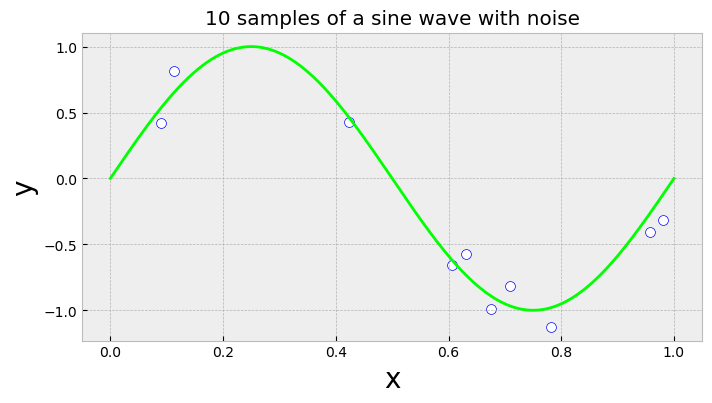

In [5]:
random_state = default_rng(21)
random_state_2 = default_rng(303)
lightgreen = '#00ff00'
### create 10 randomly sampled points from a uniform distribution
x10 = random_state.uniform(0,1,size=10)
### create the input for a smooth sine function as well
x1000 = np.linspace(0,1,1000)
### create the sine wave data points and add random noise
sine_wave = np.sin(np.pi*2*x10)+random_state_2.uniform(-0.25,0.25,10)
sine_wave_smooth = np.sin(np.pi*2*x1000)
### plot the wave using matplotlib
plt.figure(figsize=(8, 4))
plt.scatter(x10,sine_wave,s=50,edgecolor='blue',facecolor='w',marker='o')
plt.plot(x1000,sine_wave_smooth,color=lightgreen)
plt.xlabel('x',size=20)
plt.ylabel('y',size=20)
plt.title('10 samples of a sine wave with noise')
plt.show()

As discussed in Lecture 2, we fit polynomials of order $M$ to the 10 samples, i.e.
$$
y(x,\mathbf{w}) = w_0 + w_1 x + w_2 x² + ... +  w_M x^M = \sum_{j=0}^M w_j x^j
$$
Specifically, we fit $M$ = 0, 1, 3, and 9:

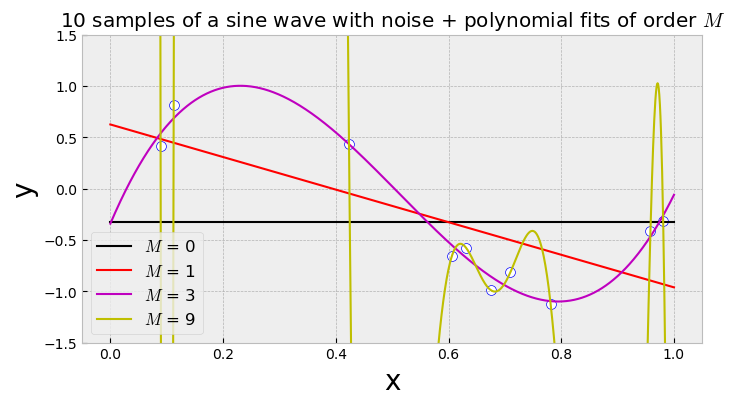

In [6]:
z0 = np.polyfit(x10,sine_wave,0)
p0 = np.poly1d(z0)
z1 = np.polyfit(x10,sine_wave,1)
p1 = np.poly1d(z1)
z3 = np.polyfit(x10,sine_wave,3)
p3 = np.poly1d(z3)
z9 = np.polyfit(x10,sine_wave,9)
p9 = np.poly1d(z9)
plt.figure(figsize=(8, 4))
plt.scatter(x10,sine_wave,s=50,color='blue',edgecolor='blue',facecolor='w',marker='o')
plt.plot(x1000,p0(x1000),color='k',label='$M$ = 0',linewidth=1.5)
plt.plot(x1000,p1(x1000),color='r',label='$M$ = 1',linewidth=1.5)
plt.plot(x1000,p3(x1000),color='m',label='$M$ = 3',linewidth=1.5)
plt.plot(x1000,p9(x1000),color='y',label='$M$ = 9',linewidth=1.5)
plt.legend(fontsize=12)
plt.xlabel('x',size=20)
plt.ylabel('y',size=20)
plt.ylim(-1.5,1.5)
plt.title('10 samples of a sine wave with noise + polynomial fits of order $M$')
plt.show()

### Part 1.1 Addressing overfitting - option 1: more data

The polynomials of orders 0 and 1 cannot fit the variance in the data, whereas $M$ = 9 overfits. The 3rd-order polynomial, however, appears to be a relatively good compromise. 

In reality and working with machine learning, we would still often want to fit very flexible functions, such as neural networks. Here, let's assume that the 9th-order polynomial is a representative of such more flexible functions.

One way to address overfitting for these flexible models would be to collect more data to train them on. To illustrate this, let's try fitting the 9th-order polynomial again, but this time using $N$ = 15 and $N$ = 100 samples to fit the function.

**Task 1.1** Complete the code below so that the right subfigure shows the 9th-order polynomial fit to $N$ = 100 samples at the already initialized x-values `x100`.

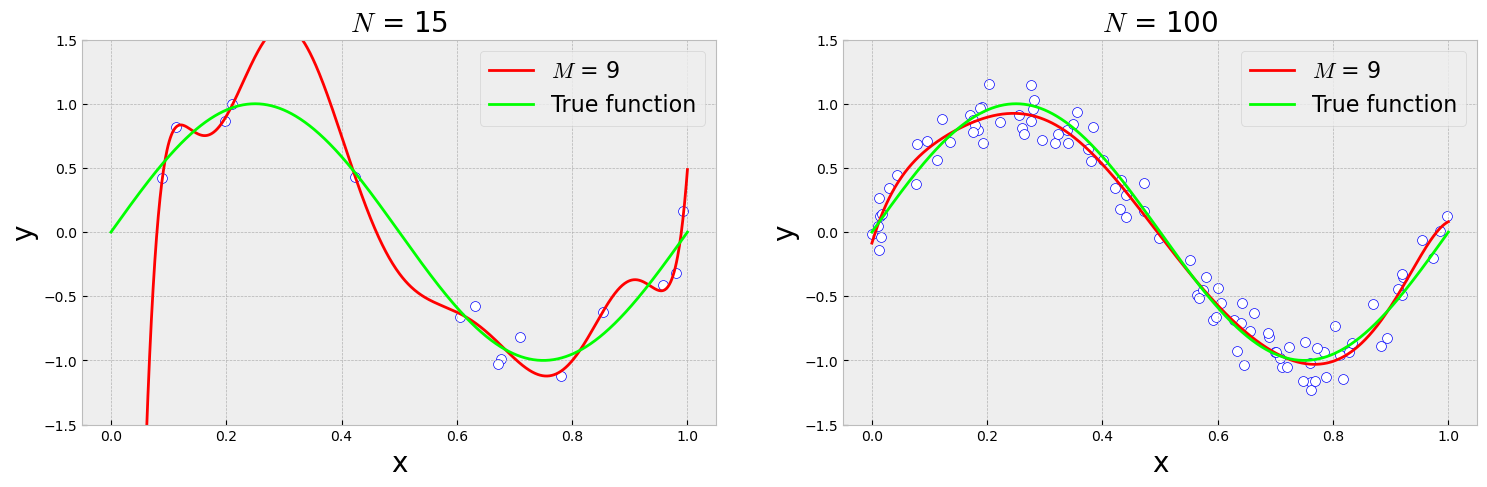

In [7]:
plt.figure(figsize=(18, 5))
random_state = default_rng(21)
random_state_2 = default_rng(303)

x15 = random_state.uniform(0,1,15)
x100 = random_state.uniform(0,1,100)

sine_wave_15 = np.sin(np.pi*2*x15)+random_state_2.uniform(-0.25,0.25,15)
sine_wave_100 = np.sin(np.pi*2*x100)+random_state_2.uniform(-0.25,0.25,100)

z9_15 = np.polyfit(x15,sine_wave_15,9)
p9_15 = np.poly1d(z9_15)

z9_100 = np.polyfit(x100,sine_wave_100,9)
p9_100 = np.poly1d(z9_100)

plt.subplot(121)
plt.scatter(x15,sine_wave_15,s=50,edgecolor='blue',facecolor='w',marker='o')
plt.plot(x1000,p9_15(x1000),color='r',label='$M$ = 9')
plt.plot(x1000,sine_wave_smooth,color=lightgreen,label='True function')
plt.legend(fontsize=16,loc='upper right')
plt.title('$N$ = 15',size=20)
plt.ylim(-1.5,1.5)
plt.xlabel('x',size=20)
plt.ylabel('y',size=20)
plt.subplot(122)

### Task 1.1

plt.scatter(x100,sine_wave_100,s=50,edgecolor='blue',facecolor='w',marker='o')
plt.plot(x1000,p9_100(x1000),color='r',label='$M$ = 9')
plt.plot(x1000,sine_wave_smooth,color=lightgreen,label='True function')
plt.legend(fontsize=16,loc='upper right')
plt.title('$N$ = 100',size=20)
plt.ylim(-1.5,1.5)
plt.xlabel('x',size=20)
plt.ylabel('y',size=20)

plt.show()

### Part 1.2 Addressing overfitting - option 2: regularization


From this new graph, it is evident and intuitive that more data helps to better constrain the variance in the 9th-order polynomial. For $N$ = 100, the resulting function would have good generalizable skill across the interval [0,1]. 

Unfortunately, in most machine learning challenges simply collecting more data is not an option. In addition, in machine learning, we usually aim to learn functions with many predictors (typically dozens to millions) so that we are also subjected to the *curse of dimensionality*, which we discussed in Lecture 2 and which you will also encounter in Parts 2 and 3 below. This means that relative to the number of predictors, the data available will in most cases be sparse.

Instead, we need to find alternative ways to constrain the variance in the 9th-order polynomial. Next, you will apply a key concept to achieve just this, called **L2-regularization.**

First, we re-formulate the 9-th order polynomial as a linear model. Second, we fit an initially *unregularized* `Ridge()` regression model from `sklearn.linear_model` (i.e. regularization parameter $\alpha$ = 0) and demonstrate that this gives equivalent results to fitting a 9th-order polynomial using `numpy.polyfit()` above.

Again, ridge regression will allow us to carry out a multiple linear regression (MLR) with L2-regularization. However, first we set the regularization parameter $\alpha$ to 0 to emulate the case of a simple linear 9th-order polynomial fit without regularization (i.e. MLR). You will learn more about ridge regression in Lecture 3 and can find further detail in its `sklearn` [function documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html). The regression logic for training and prediction follows the standard `sklearn` sequence of

(a) define the regression object

(b) `.fit()`

(c) `.predict()`

which you have already encountered in Task 2 of Worksheet 1.

The mean squared error of your prediction on 1000 values of x is: 0.01


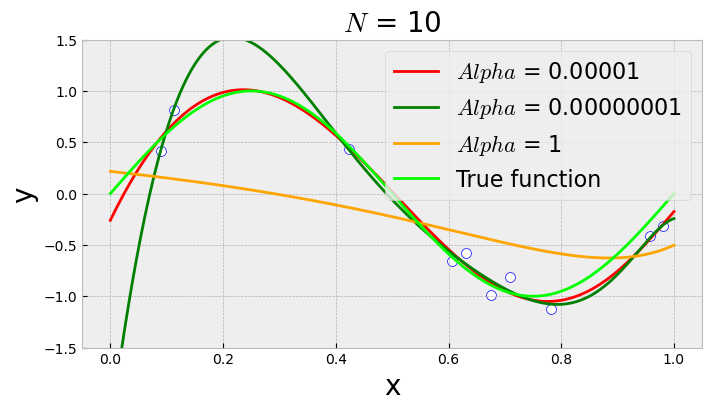

In [8]:
# arange predictor matrix, adding transformations of 'x' up to order 9
X=np.vstack((x10**0,x10,x10**2,x10**3,x10**4,x10**5,x10**6,x10**7,x10**8,x10**9))
X=X.T
# create inputs for a smooth function later on
X1000=np.vstack((x1000**0,x1000,x1000**2,x1000**3,x1000**4,x1000**5,x1000**6,x1000**7,x1000**8,x1000**9))
X1000=X1000.T
# the sine wave we fit is still the same.
Y=sine_wave

reg = Ridge(alpha=0.00001,fit_intercept=True, random_state=42)
reg.fit(X,Y)
y_pred = reg.predict(X1000)

re = Ridge(alpha=0.00000001,fit_intercept=True, random_state=42)
re.fit(X,Y)
y_pre = re.predict(X1000)

r = Ridge(alpha=1,fit_intercept=True, random_state=42)
r.fit(X,Y)
y_pr = r.predict(X1000)

plt.figure(figsize=(8, 4))
plt.scatter(x10,sine_wave,s=50,edgecolor='blue',facecolor='w',marker='o')
plt.plot(x1000,y_pred,color='r',label='$Alpha$ = 0.00001')
plt.plot(x1000,y_pre,color='g',label='$Alpha$ = 0.00000001')
plt.plot(x1000,y_pr,color='orange',label='$Alpha$ = 1')
plt.plot(x1000,sine_wave_smooth,color=lightgreen,label='True function')
plt.legend(fontsize=16,loc='upper right')
plt.title('$N$ = 10',size=20)
plt.ylim(-1.5,1.5)
plt.xlabel('x',size=20)
plt.ylabel('y',size=20)
print('The mean squared error of your prediction on 1000 values of x is: ' +str(round(mean_squared_error(y_pred,sine_wave_smooth),2)))
plt.show()

**Task 1.2** In the `Ridge()` regression object above, increase the value of $\alpha$ to various positive values. What do you observe? Does the fit generally get better than for the unregularized case?

*Hint*: also try out very small positive values for $\alpha$.

In [9]:
### Task 1.2
answer_tuning_alpha_manually = "There seems to be a sweet spot around alpha = 0.00001. For smaller alphas the model overfits similarly to the untuned model (where alpha is 0). On the other hand the fit gets more linear the larger alpha is. This is because for large penalty terms the model avoids using higher order polynomials. For very small penalty terms it uses the highest polynomial available so that it can fit the data exactly, thus overfitting."
# YOUR CODE HERE
print(answer_tuning_alpha_manually)

There seems to be a sweet spot around alpha = 0.00001. For smaller alphas the model overfits similarly to the untuned model (where alpha is 0). On the other hand the fit gets more linear the larger alpha is. This is because for large penalty terms the model avoids using higher order polynomials. For very small penalty terms it uses the highest polynomial available so that it can fit the data exactly, thus overfitting.


#### Cross-validation of the $\alpha$ hyperparameter

Now it's time to fix the poor generalization performance of the 9th-order polynomial in a more systematic fashion.

To achieve this, choose one of two options to systematically vary the L2-regularization parameter $\alpha$ across the following list of values:

[1e-06, 1e-05, 1e-04, 1e-03, 1e-02, 1e-01, 1e+00, 1e+01, 1e+02, 1e+03, 1e+04, 1e+05, 1e+06]

The two options are:

1) Combine `sklearn`'s `Ridge()` function with a `GridSearchCV()` object. You can find examples for how to do this in its documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html), just scroll to the bottom of the page.
2) More directly use the `RidgeCV()` function from `sklearn`, which is a ridge regression object with built-in cross-validation, see its documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html).

Either way, use a strategy called [leave-one-out cross-validation](https://machinelearningmastery.com/loocv-for-evaluating-machine-learning-algorithms). Note that for 10 samples this is equivalent to a 10-fold cross-validation strategy. For convenience, we have already imported both `GridSearchCV()` and `RidgeCV()` for you at the top of this worksheet. 

**Task 1.3** Carry out the cross-validation using at least one of the two approaches suggested. Once you have trained and cross-validated your function on the 10 samples in `X` and `Y`, use this function to make predictons on the `X1000` input defined above and:
1) Estimate the `mean_squared_error()` of these predictions relative to `sine_wave_smooth`, and assign its value to `best_mse_cv_polynomial`.
2) Pass the best $\alpha$ value according to your cross-validation to the variable `best_alpha_polynomial` for evaluation after upload to Ilias. You might want to use `RidgeCV()` and `GridSearchCV()` attributes such as `.best_estimator_`, `.alpha_`, or `.alpha` depending on the path you choose.

In [10]:
### Task 1.3
best_mse_cv_polynomial = None
best_alpha_polynomial = None
alphas = [1e-06, 1e-05, 1e-04, 1e-03, 1e-02, 1e-01, 1e+00, 1e+01, 1e+02, 1e+03, 1e+04, 1e+05, 1e+06]

# Use cv = None to use LeaveOneOut()
ridgeCV = RidgeCV(alphas, cv = None)
ridgeCV.fit(X,Y)
y_pred = ridgeCV.predict(X1000)
best_alpha_polynomial = ridgeCV.alpha_
best_mse_cv_polynomial = ridgeCV.best_score_

print(f"The best mse is {abs(best_mse_cv_polynomial)} when using {best_alpha_polynomial} as alpha.")

The best mse is 0.04067195980949926 when using 0.0001 as alpha.


**Task 1.4** Use `matplotlib` to visualize the 10 samples, the true sine wave function, and your new cross-validated 9th-order polynomial predictions on `X1000`. 

You are allowed to re-use code from above. Add sensible labels and make clear in the title that this is a fit on 10 samples.

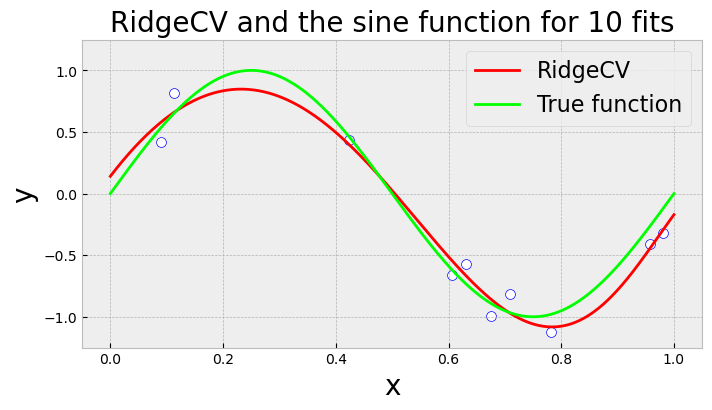

In [11]:
plt.figure(figsize=(8, 4))
plt.plot(x1000,y_pred,color='r', label ='RidgeCV')
plt.plot(x1000,sine_wave_smooth,color=lightgreen,label='True function')
plt.scatter(x10,sine_wave,s=50,edgecolor='blue',facecolor='w',marker='o')
plt.legend(fontsize=16,loc='upper right')
plt.title('RidgeCV and the sine function for 10 fits',size=20)
plt.ylim(-1.25,1.25)
plt.xlabel('x',size=20)
plt.ylabel('y',size=20)
plt.show()

## Part 2 - Global warming revisited

- Last week you modelled historical global warming as a function of concentrations in atmospheric carbon dioxide (CO$_2$) and of various modes of climate variability. Back then we measured climate variability through a set of standard "indices".
- Here, you will take a high-dimensional data science approach to this problem. Instead of the small set of indices, you will use global sea level pressure fields to characterize the internal dynamical state of Earth's atmosphere, on top of the trend driven by CO$_2$.

For this, we will download [sea level pressure (SLP)](https://w1.weather.gov/glossary/index.php?word=sea+level+pressure) data from the [NCEP-NCAR-reanalysis-I](https://psl.noaa.gov/data/gridded/data.ncep.reanalysis.html). This data represents an estimate of monthly-mean fluctuations in SLP from the year January 1948 to October 2024, at 2.5$\degree$ latitude $\times$ 2.5$\degree$ longitude spatial resolution.

SLP is hardly influenced by trends in surface temperature. Instead, it can be seen as an almost pure representation of the internal dynamical variability of Earth's atmosphere, which makes it a useful "orthogonal" variable to CO$_2$.

The next few (admittedly tedious) cells are required to fetch and load the monthly regional SLP data, the monthly NASA global mean temperature data (cf. Worksheet 1) and the monthly CO$_2$ data (cf. Worksheet 1, upsampled from annual mean data). 

We make sure to end up with array definitions that span a consistent time period from January 1948 to August 2024.

In [12]:
# fetch and process sea level pressure data
# already done for you, we have moved it into the subfolder "data"
# slp_file = netCDF4.Dataset(MLclimate.fetch_data('https://downloads.psl.noaa.gov/Datasets/ncep.reanalysis/Monthlies/surface/slp.mon.mean.nc','slp.mon.mean.nc'))
# read out the variable, time dimension, and longitude-latitude coordinates, for background info see also Worksheet 1
# constrain this data in time for consistency with the temperature data later on
slp_file = netCDF4.Dataset('./data/slp.mon.mean.nc')
nr_months = 920
slp_lon = slp_file['lon'][:]
slp_lat = slp_file['lat'][:]
slp_mm_1948_2024 = slp_file['slp'][:nr_months,:,:]
slp_time = netCDF4.num2date(slp_file['time'][:nr_months],slp_file['time'].units)
# check time interval
print(slp_time[0],slp_time[nr_months-1])
# dimensions are: time, lat, lon
print(slp_mm_1948_2024.shape)

1948-01-01 00:00:00 2024-08-01 00:00:00
(920, 73, 144)


In [13]:
# now let's load once again the monthly-mean global warming data from Worksheet 1.
# Then we select the same time interval as for the SLP data
# All that might take a minute...
idx_nasa_1948 = (1948-1880)*12
nasa_mm_file = netCDF4.Dataset('./data/gistemp1200_GHCNv4_ERSSTv5_fldmean.nc')
### On Google Colab: comment out the line above and instead uncomment and execute the following:
# from google.colab import files
# uploaded = files.upload() 
### in the pop-up window "Choose Files" the gistemp_monthly_mean.nc file from the /data/ directory in your exercise folder
# nasa_mm_file = netCDF4.Dataset('gistemp_monthly_mean.nc')
nasa_mm_1948_2024 = nasa_mm_file['tempanomaly'][idx_nasa_1948:,0,0]
nasa_time = netCDF4.num2date(nasa_mm_file['time'][idx_nasa_1948:],nasa_mm_file['time'].units)
print(nasa_time[0],nasa_time[-1])

1948-01-15 00:00:00 2024-08-15 00:00:00


In [14]:
# next we load the CO2 data and constrain it to January 1948 - August 2024
# again, we have prepared this for you and have put this into the folder "data"
# co2_am_file_1850_2014 = MLclimate.fetch_data("https://files.isimip.org/ISIMIP3b/InputData/climate/atmosphere_composition/co2/historical/co2_historical_annual_1850_2014.txt","co2_historical_annual_1850_2014.txt")
co2_am_1850_2014 = pd.read_csv('./data/co2_historical_annual_1850_2014.txt',header=None,delim_whitespace=True,names=['Year','CO2 (ppmv)'])
# co2_am_file_2015_2024 = MLclimate.fetch_data("https://files.isimip.org/ISIMIP3b/InputData/climate/atmosphere_composition/co2/ssp126/co2_ssp126_annual_2015_2100.txt","co2_ssp126_annual_2015_2100.txt")
co2_am_2015_2024 = pd.read_csv('./data/co2_ssp126_annual_2015_2100.txt',header=None,delim_whitespace=True,names=['Year','CO2 (ppmv)'])
co2_am_1948_2024 = pd.concat([co2_am_1850_2014[co2_am_1850_2014['Year'] >= 1948],co2_am_2015_2024[co2_am_2015_2024['Year'] < 2026]]).reset_index(drop=True)
co2_am_1948_2024.Year = pd.to_datetime(co2_am_1948_2024.Year,format='%Y')
co2_am_1948_2024 = co2_am_1948_2024.to_xarray()
co2_am_1948_2024 = co2_am_1948_2024.set_coords('Year').swap_dims({'index': 'Year'})
### the CO2 data is only available at yearly temporal resolution, so we upsample the data according to the nearest timestamp to monthly frequency
co2_mm_1948_2024 = co2_am_1948_2024.resample(Year='1M').nearest().to_dataframe()['CO2 (ppmv)'][:-5]
co2_mm_1948_2024 = np.array(co2_mm_1948_2024.values)[:,np.newaxis]

C:\Users\mfher\AppData\Local\Temp\ipykernel_22508\3071244442.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  co2_am_1850_2014 = pd.read_csv('./data/co2_historical_annual_1850_2014.txt',header=None,delim_whitespace=True,names=['Year','CO2 (ppmv)'])
C:\Users\mfher\AppData\Local\Temp\ipykernel_22508\3071244442.py:6: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  co2_am_2015_2024 = pd.read_csv('./data/co2_ssp126_annual_2015_2100.txt',header=None,delim_whitespace=True,names=['Year','CO2 (ppmv)'])
C:\Users\mfher\.julia\conda\3\x86_64\envs\mlclimat\Lib\site-packages\xarray\groupers.py:392: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(


**Task 2.1** To illustrate the approximate climate-invariance of the sea level pressure data stored in `slp_mm_1948_2024[:,:,:]`, create four subplots of SLP histories at four randomly chosen grid locations, i.e. show the location-dependent evolution of monthly SLP over time. You may re-use code from the beginning of Task 2 of Worksheet 1.

In [15]:
np.random.seed = 17

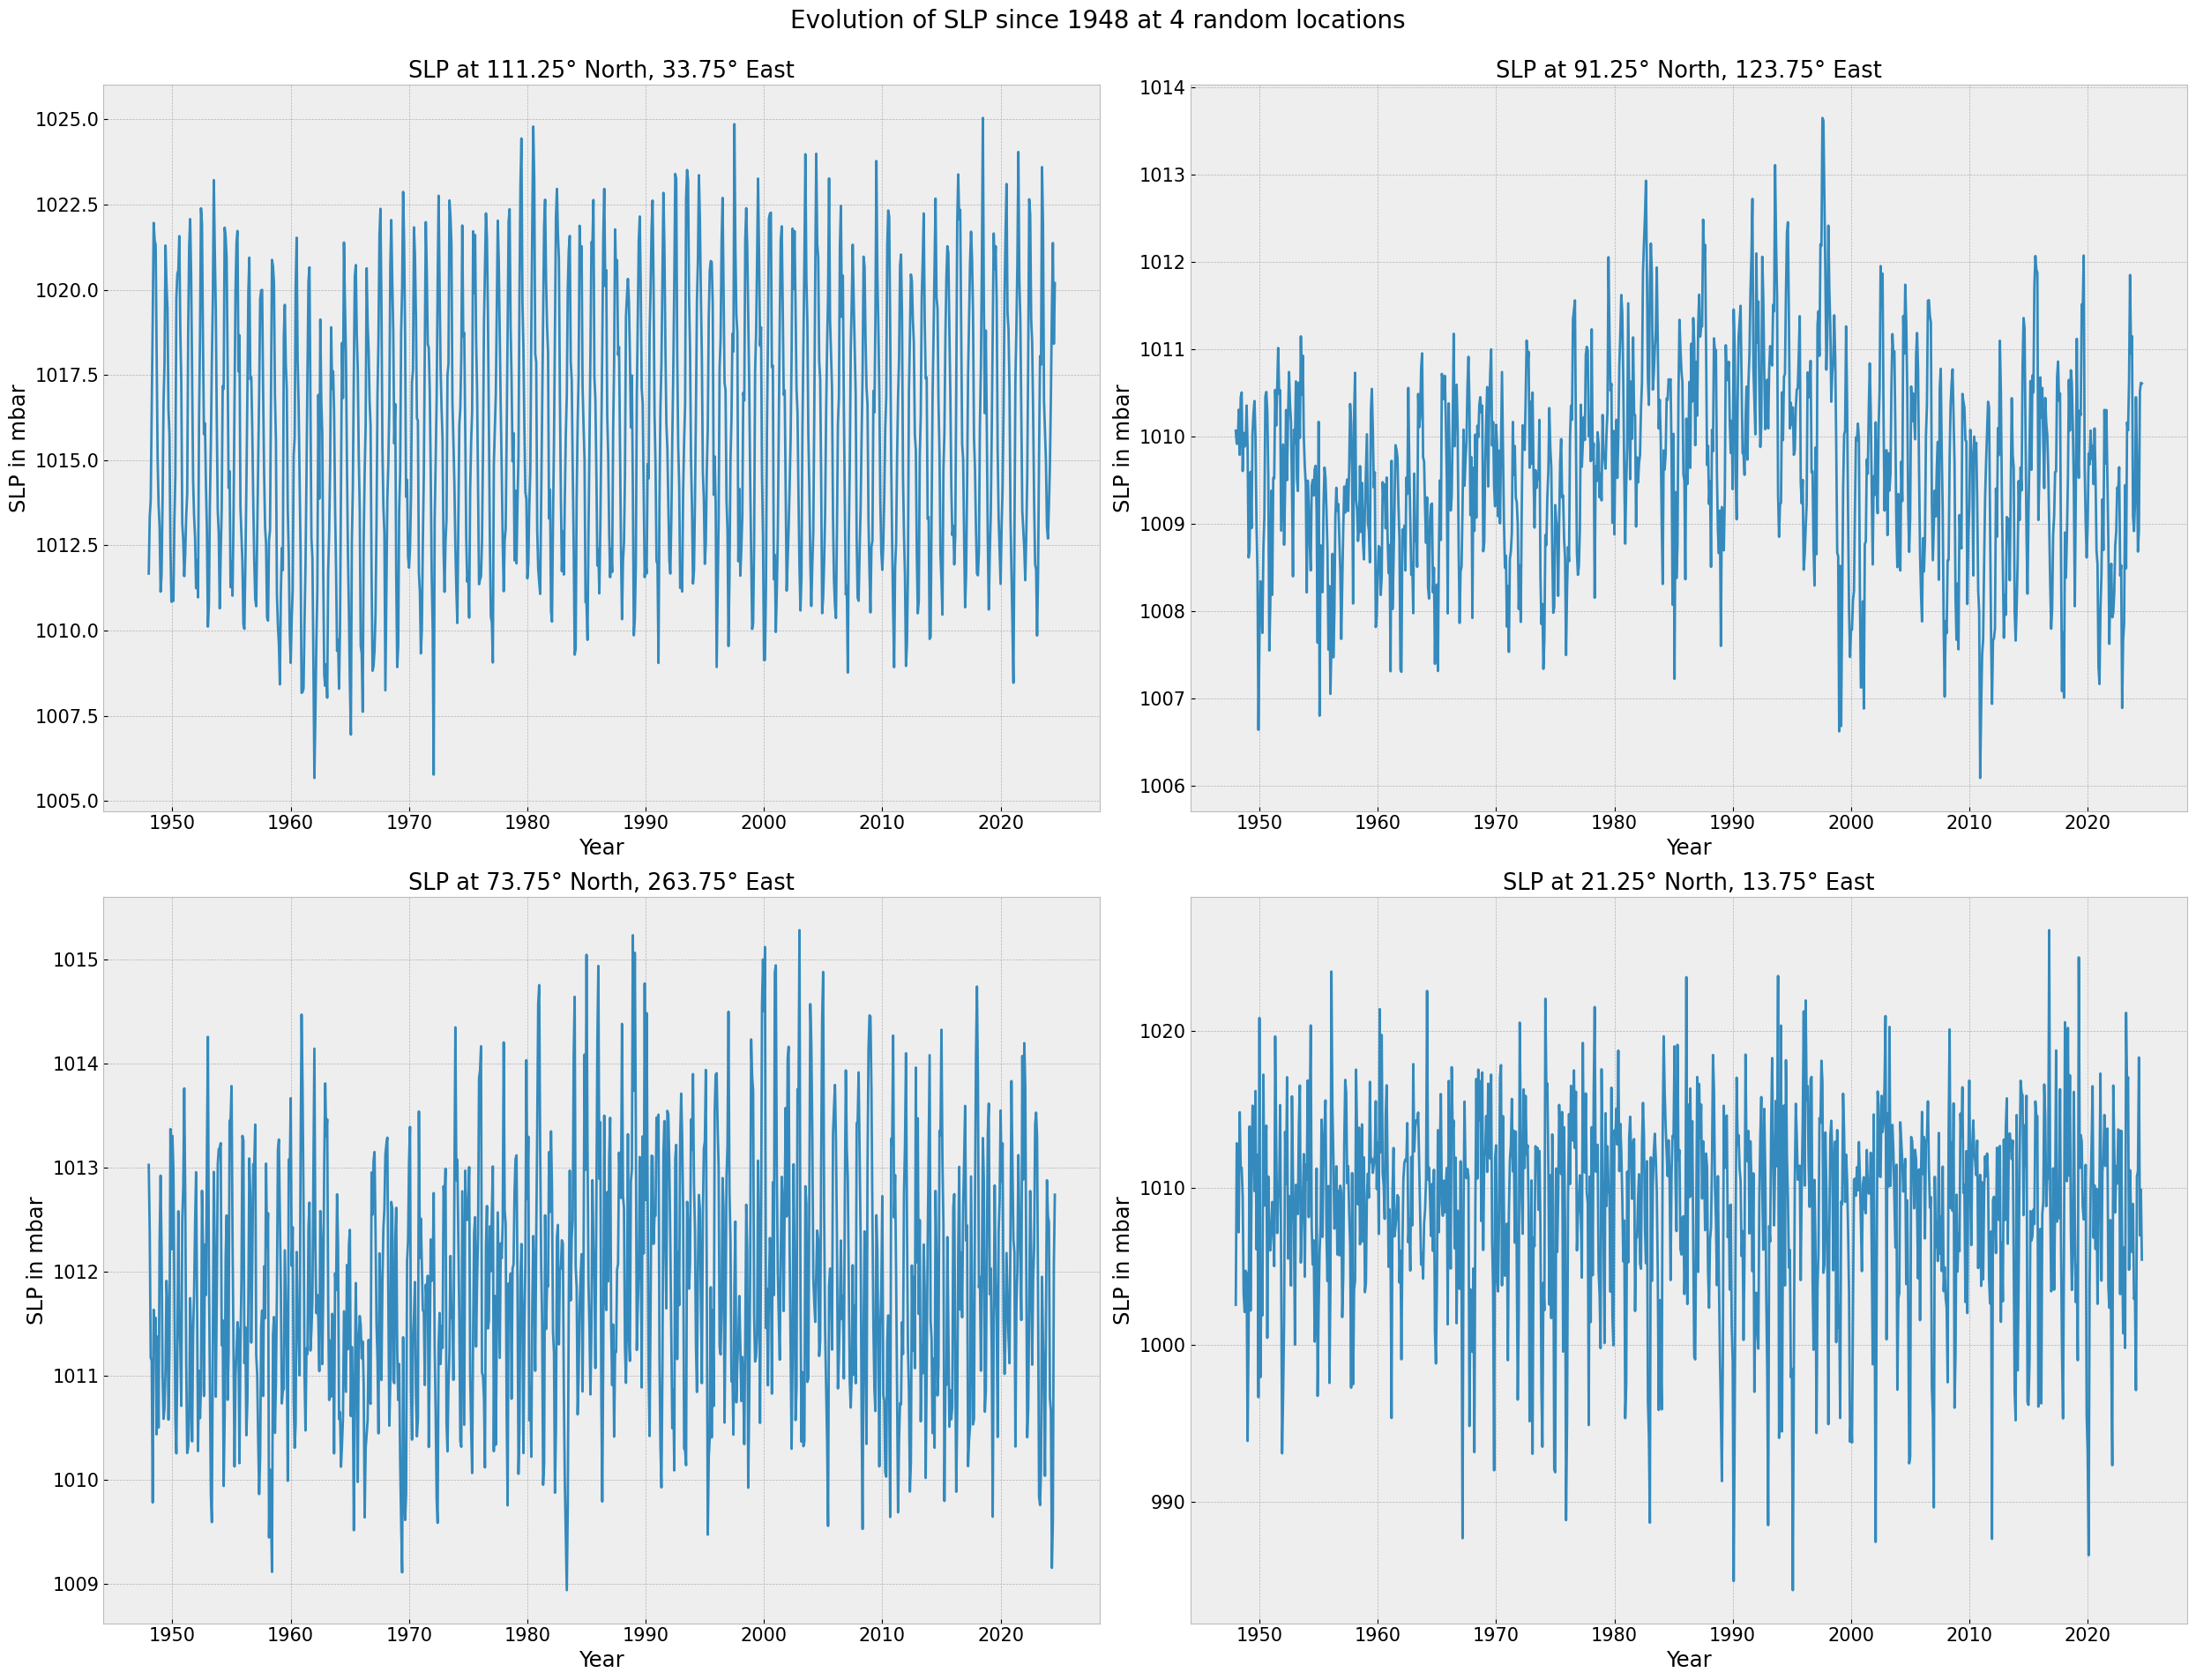

In [16]:
# Task 2.1
plt.figure(figsize=(25, 20))
yrs = ['1950', '1960', '1970', '1980', '1990', '2000', '2010', '2020']

for i in range(1,5,1):
    plt.subplot(2, 2, i)
    x = np.random.randint(0, 73)
    y = np.random.randint(0, 144)
    plt.plot(slp_mm_1948_2024[:,x,y])
    
    plt.xlabel("Year", fontsize=17.5)
    plt.ylabel("SLP in mbar", fontsize=17.5)
    plt.xticks(np.arange(0, 8)*120+24, yrs, fontsize=15)
    plt.yticks(fontsize=15)
    
    plt.title(f"SLP at {(x-1)*2.5+1.25}° North, {(y-1)*2.5+1.25}° East", fontsize=18.5)
    

    
plt.suptitle('Evolution of SLP since 1948 at 4 random locations', fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()

#### Cartopy for surface maps

An alternative way to visualize Earth system data are surface maps, which can for example be created with the Python package `cartopy`. You can find many examples for geospatial data mapping in its [documentation](https://scitools.org.uk/cartopy/docs/latest/gallery/index.html).

To provide one example here, let's visualize the SLP map for September 2023:

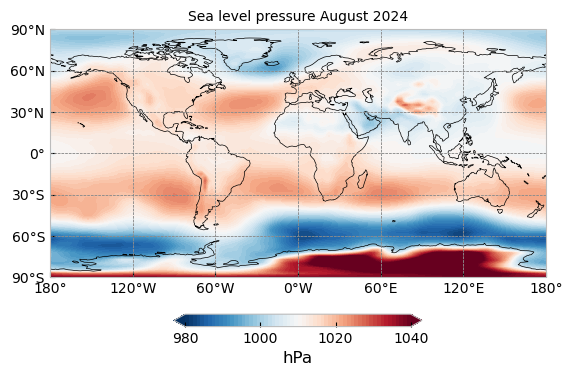

In [17]:
# example cartopy plot, see if you can derive the meaning of each point
ax = plt.axes(projection=cartopy.crs.PlateCarree(central_longitude=0))
ax.set_global()
ax.gridlines(linestyle='--',color='gray')
clevs = np.arange(980,1041,1)
slp_cyclic, slp_lon_cyclic = add_cyclic_point(slp_mm_1948_2024,coord=slp_lon)
plt.contourf(slp_lon_cyclic,slp_lat,slp_cyclic[-1],clevs,cmap='RdBu_r',extend='both',transform = cartopy.crs.PlateCarree())
colorbar = plt.colorbar(ax=ax,orientation='horizontal',pad=0.1,aspect=20,shrink=0.5,ticks=np.array([980,1000,1020,1040]))
colorbar.set_label("hPa",size=12,rotation=0)
colorbar.ax.tick_params(labelsize = 10)
ax.set_xticks([-180,-120,-60,0, 60, 120, 180], crs=cartopy.crs.PlateCarree())
ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=cartopy.crs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.coastlines()
plt.title('Sea level pressure August 2024',size=10)
plt.show()

**Task 2.2** Use the `Linear_Regression()` and `Ridge()` model objects from the `sklearn` package to `.fit()` and `.predict()` NASA global mean temperatures (`nasa_mm_1948_2024`) from the historical global mean CO$_2$ (`co2_mm_1948_2024`) and regional SLP (`slp_mm_1948_2024`) evolution; the latter across all 2.5$\degree\times$2.5$\degree$ grid boxes globally. Owing to the large number of SLP predictors, this will result in a high-dimensional regression problem and in an underdetermined problem (number samples < number predictors) which can only be approximated numerically, which happens automatically when you use the `sklearn` functions.

As always, you may re-use code from Worksheet 1 where applicable.

Proceed in the following steps:
1. Combine the predictor data (CO$_2$, SLP) into one large matrix `X` of dimensions (number_timesteps, number_predictors)
2. Split the predictor and predictand data into training and test datasets: `X_train` and `y_train` and `X_test` and `y_test`. Use the period January 2000 to December 2009 for testing. Use all other months for training (and cross-validation, for ridge). See Worksheet 1 how you can for example use `np.delete()` to un/select the corresponding indices.
3. Fit the multiple linear regression to the training data.
4. Use the `StandardScaler()` object from `sklearn.preprocessing`, see [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html), to scale all predictors to zero mean and unit standard deviation according to the samples in the training data. Then apply this transformation to both training and test data, to define new matrices `X_train_scaled` and `X_test_scaled`.
5. Train the ridge regression model in combination with a `GridSearchCV()` object using 5-fold cross-validation, using `X_train_scaled` for the predictors. For the list of regularization parameters $\alpha$ used in cross-validation, run multiple iterations in which you narrow down on an increasingly fine-grained range around the best $\alpha$ selected. Repeat this until the final results are not particularly sensitive anymore to further finetuning of $\alpha$. Make sure to set the `random_state` variable in `Ridge()` to the value 101 for reproducibility.
6. Use both functions to predict the period January 2000 to December 2009.
7. `.print()` the mean squared error for both methods over this test period.
8. Assign these values to the matchingly named variables `mse_mlr_global` and `mse_ridge_global` for autograding.
9. Save the most optimized `alpha` value of your `.best_estimator_` for the ridge regression to the variable `best_alpha_global`. Don't worry about hitting the `alpha` value precisely, a range of values will be accepted as close enough.

**Task 2.3** Using `matplotlib`, visualize the three time series (true NASA, MLR predicted, and ridge predicted) for the test period January 2000 to December 2009. Make sure to add sensible labels etc. In addition, calculate the corresponding [Pearson correlation coefficients](https://numpy.org/doc/stable/reference/generated/numpy.corrcoef.html) and [r2-scores](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html) for both regression methods and add this info to the figure title. In the title, remember to convert numbers to `str()` and you can use `round()` to avoid printing too many decimals.

In [18]:
# Temp
nasa_mm_1948_2024
# co2
co2_mm_1948_2024
# SLP

print(nasa_mm_1948_2024.shape, co2_mm_1948_2024.shape)

v = np.column_stack((co2_mm_1948_2024, slp_mm_1948_2024.reshape(920, -1)))

mask = np.ones(v.size, dtype=bool)
mask = mask.reshape(v.shape)
mask[(2000-1948)*12:(2009-1948)*12] = False

x_train = v[mask].reshape(812, v.shape[1])
x_test = v[(2000-1948)*12:(2009-1948)*12]

mask = np.ones(nasa_mm_1948_2024.size, dtype=bool)
mask[(2000-1948)*12:(2009-1948)*12] = False

y_train = nasa_mm_1948_2024[mask]
y_test = nasa_mm_1948_2024[(2000-1948)*12:(2009-1948)*12]


(920,) (920, 1)


In [19]:
print(x_train.shape, y_train.shape, "\n",x_test.shape, y_test.shape)

(812, 10513) (812,) 
 (108, 10513) (108,)


In [20]:
mse_mlr_global = None

MLR = LinearRegression()
MLR.fit(x_train,y_train)
y_pred_MLR = MLR.predict(x_test)
mse_mlr_global = mean_squared_error(y_test,y_pred_MLR)
print('MSE for global MLR: ',round(mse_mlr_global,5))

MSE for global MLR:  0.02312


In [21]:
scaler = StandardScaler()
scaler.fit(x_train)

x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [22]:
mse_ridge_global = None
best_alpha_global = None

# Initial guess
guess = 10
count = 0

for i in np.arange(0,99):
    best_alpha = np.arange(guess/2, guess*3/2, guess/10)

    ridgeCVMR = RidgeCV(best_alpha, cv = 5)
    ridgeCVMR.random_state = 101
    
    ridgeCVMR.fit(x_train_scaled,y_train)
    y_pred = ridgeCVMR.predict(x_test_scaled)
    if guess == ridgeCVMR.alpha_:
        count += 1
        if count > 5:
            print("\nConvergence detected. Stopping...\n")
            break
    else:
        count = 0
    
    guess = ridgeCVMR.alpha_
    print(f"Current alpha: {guess}")

mse_ridge_global = mean_squared_error(y_test,y_pred)
best_alpha_global = guess

print(f"The best mse is {abs(round(mse_ridge_global,5))} when using {best_alpha_global} as alpha.")

Current alpha: 14.0
Current alpha: 19.6
Current alpha: 27.44000000000001
Current alpha: 38.41600000000002
Current alpha: 42.257600000000025
Current alpha: 42.25760000000002
Current alpha: 42.25760000000001
Current alpha: 42.25760000000001
Current alpha: 42.25760000000001
Current alpha: 42.25760000000001
Current alpha: 42.25760000000001
Current alpha: 42.25760000000001

Convergence detected. Stopping...

The best mse is 0.01443 when using 42.25760000000001 as alpha.


In [23]:
plotmlr = np.ones(920)

plotmlr[:] = np.nan
plotmlr[(2000-1948)*12:(2009-1948)*12] = y_pred_MLR

In [24]:
plotrdg = np.ones(920)
plotrdg[:] = np.nan
plotrdg[(2000-1948)*12:(2009-1948)*12] = y_pred

Text(0.5, 0.98, 'Temperature relative to the 1951 to 1980 average')

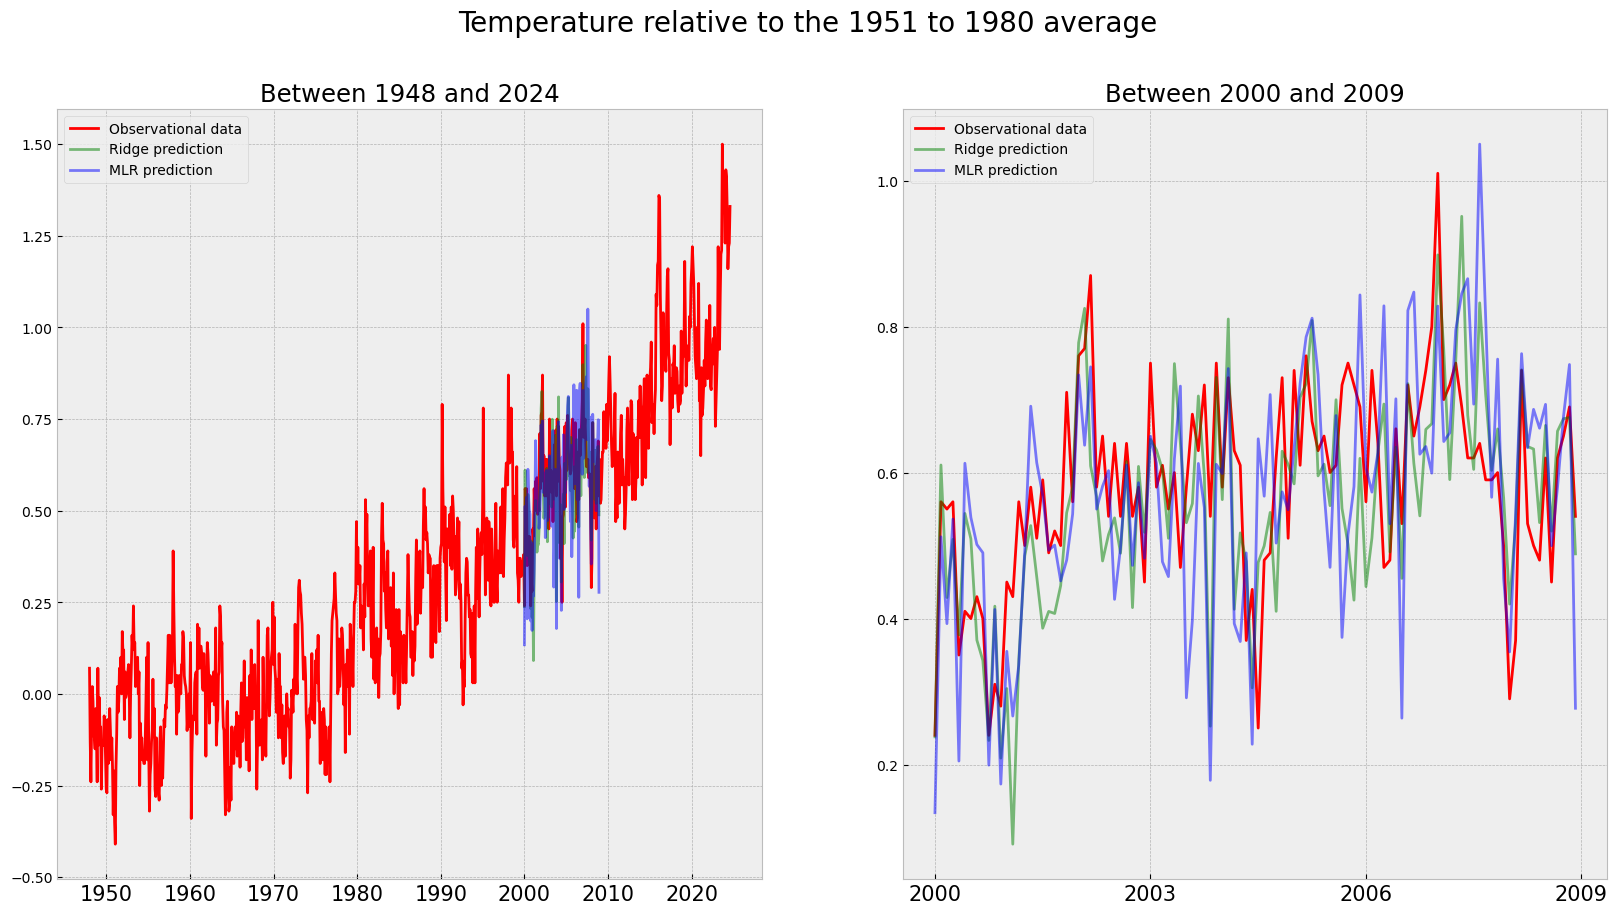

In [25]:
# Task 2.3
yrs10 = ['1950', '1960', '1970', '1980', '1990', '2000', '2010', '2020']
yrs3 = ['2000', '2003', '2006', '2009']
fig, ax = plt.subplots(1,2, figsize=(20,10))

ax[0].plot(nasa_mm_1948_2024, color = 'r', label='Observational data')
ax[0].plot(plotrdg, color = 'g', alpha = 0.5, label='Ridge prediction')
ax[0].plot(plotmlr, color = 'b', alpha = 0.5, label='MLR prediction')
ax[0].set_xticks(np.arange(0, 8)*120+24, yrs10, fontsize=15)
ax[0].set_title('Between 1948 and 2024', fontsize=17.5)
ax[0].legend()

ax[1].plot(y_test, color = 'r', label='Observational data')
ax[1].plot(y_pred, color = 'g', alpha = 0.5, label='Ridge prediction')
ax[1].plot(y_pred_MLR, color = 'b', alpha = 0.5, label='MLR prediction')
ax[1].set_xticks(np.arange(0, 4)* 36, yrs3, fontsize=15)
ax[1].set_title('Between 2000 and 2009', fontsize=17.5)
ax[1].legend()

fig.suptitle('Temperature relative to the 1951 to 1980 average', fontsize=20)

**Task 2.4** Which of the two linear models performs better? Can you explain this result?

In [26]:
print(f"MSE of MLR on the training data: {mean_squared_error(y_train,MLR.predict(x_train))}")
print(f"MSE of Ridge on the training data: {mean_squared_error(y_train,ridgeCVMR.predict(x_train_scaled))}")

MSE of MLR on the training data: 6.99767032305637e-27
MSE of Ridge on the training data: 0.0018091997788119202


In [27]:
# Task 2.4
answer_curse = "The ridge model performs almost double as well, although the difference between the MSE is not that great since the MSE was very small to begin with. When comparing the MSE on the training data it is observable that the MLR overfits very heavily. This leads to a worse generalization on unseen data. This kind of behaviour can be penalized using L2 regularization in Ridge, leading to a less overfitted model and thus better predictions."
# YOUR CODE HERE
print(answer_curse)

The ridge model performs almost double as well, although the difference between the MSE is not that great since the MSE was very small to begin with. When comparing the MSE on the training data it is observable that the MLR overfits very heavily. This leads to a worse generalization on unseen data. This kind of behaviour can be penalized using L2 regularization in Ridge, leading to a less overfitted model and thus better predictions.


**Task 2.5** Can you explain why we needed to scale the predictors prior to carrying out the ridge regression?

In [28]:
# Task 2.5
answer_scaling = "Because it uses a penalty term. If we do not scale the predictors, those with larger values will be penalized less in the L2-term so that smaller parameters also have the same effect on the prediction."

print(answer_scaling)

Because it uses a penalty term. If we do not scale the predictors, those with larger values will be penalized less in the L2-term so that smaller parameters also have the same effect on the prediction.


## Part 3 - Regional warming in the Karlsruhe area

Above and in Worksheet 1, you modelled historical changes in **global mean** surface temperature using various factors of internal variability as well as changes in atmospheric CO$_2$ concentrations.

In this part, we will look at how the global warming signal translates into regional surface warming. For this, we download and process a higher level NASA dataset, which also includes latitude-longitude resolution of historical Earth surface temperatures since 1880, even though we will again constrain ourselves to the period 1948 onwards.

In [29]:
### fetch NASA GISTEMP temperature data
### we have done this for you and put the file in the "data" folder again
# data_url_regional = "https://data.giss.nasa.gov/pub/gistemp/gistemp1200_GHCNv4_ERSSTv5.nc.gz"
# data_file_regional = "gistemp250_GHCNv4.nc.gz"
# data_file_regional = MLclimate.fetch_data(data_url_regional,data_file_regional)
nasa_regional_nc = MLclimate.open_netcdf('./data/gistemp1200_GHCNv4_ERSSTv5.nc')
print(nasa_regional_nc)

<class 'netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    title: GISTEMP Surface Temperature Analysis
    institution: NASA Goddard Institute for Space Studies
    source: http://data.giss.nasa.gov/gistemp/
    Conventions: CF-1.6
    history: Created 2024-09-08 11:48:21 by SBBX_to_nc 2.0 - ILAND=1200, IOCEAN=NCDC/ER5, Base: 1951-1980
    dimensions(sizes): lat(90), lon(180), time(1736), nv(2)
    variables(dimensions): float32 lat(lat), float32 lon(lon), int32 time(time), int32 time_bnds(time, nv), int16 tempanomaly(time, lat, lon)
    groups: 


#### Data extraction and exploration

As implied by the last output, we now have a readable netCDF dataset, in the CLASSIC netCDF4 format but also compatible with the former NETCDF3_CLASSIC format.

The file info contains e.g. a title, the publisher (NASA Goddard Institute for Space Studies), and the dimensionality of the gridded temperature data: there are 90 latitude coordinates, 180 for longitude, and 1736 timesteps.

Let's explore this dataset further. First, we will list the variables and then read out the actual latitude, longitude coordinates, the time dimension, and the actual temperature data on the latitude-longitude grid.


In [30]:
lat_nasa = nasa_regional_nc['lat'][:]
lon_nasa = nasa_regional_nc['lon'][:]
time_nasa = nasa_regional_nc['time'][:]

#### Latitude and longitude
The latitude data runs from -89.0 to 89.0, in 2$\degree$ latitude resolution. By convention negative numbers stand for Southern Hemisphere grid locations. Positive numbers stand for latitudes in the Northern Hemisphere. 0$\degree$ latitude marks the equator.

The longitude spatial resolution is also 2$\degree$ and runs from -179$\degree$ to 179$\degree$. 
In this case, 0$\degree$ is defined as running along the [null meridian in Greenwich, London, UK](https://www.britannica.com/place/Greenwich-meridian). Negative numbers move towards the west of that location, positive towards the east.
At $\pm$180$\degree$ the two directions meet, because the Earth is a sphere.

In [31]:
print("Latitudes\n", lat_nasa,"\n")
print("Longitudes\n", lon_nasa)

Latitudes
 [-89. -87. -85. -83. -81. -79. -77. -75. -73. -71. -69. -67. -65. -63.
 -61. -59. -57. -55. -53. -51. -49. -47. -45. -43. -41. -39. -37. -35.
 -33. -31. -29. -27. -25. -23. -21. -19. -17. -15. -13. -11.  -9.  -7.
  -5.  -3.  -1.   1.   3.   5.   7.   9.  11.  13.  15.  17.  19.  21.
  23.  25.  27.  29.  31.  33.  35.  37.  39.  41.  43.  45.  47.  49.
  51.  53.  55.  57.  59.  61.  63.  65.  67.  69.  71.  73.  75.  77.
  79.  81.  83.  85.  87.  89.] 

Longitudes
 [-179. -177. -175. -173. -171. -169. -167. -165. -163. -161. -159. -157.
 -155. -153. -151. -149. -147. -145. -143. -141. -139. -137. -135. -133.
 -131. -129. -127. -125. -123. -121. -119. -117. -115. -113. -111. -109.
 -107. -105. -103. -101.  -99.  -97.  -95.  -93.  -91.  -89.  -87.  -85.
  -83.  -81.  -79.  -77.  -75.  -73.  -71.  -69.  -67.  -65.  -63.  -61.
  -59.  -57.  -55.  -53.  -51.  -49.  -47.  -45.  -43.  -41.  -39.  -37.
  -35.  -33.  -31.  -29.  -27.  -25.  -23.  -21.  -19.  -17.  -15.  -13.
  -11.

More info on each variable can be extracted with `.variable['VAR_NAME']`.

For example, this concerns the units, which for longitude is "degrees east" (i.e. negative longitudes are located towards the west).

In [32]:
nasa_regional_nc.variables['lon']

<class 'netCDF4.Variable'>
float32 lon(lon)
    standard_name: longitude
    long_name: Longitude
    units: degrees_east
unlimited dimensions: 
current shape = (180,)
filling on, default _FillValue of 9.969209968386869e+36 used

#### Time
As in Worksheet 1, we can handle the at first confusing time dimension with its range of values [29233, 81...] using standard `netCDF4` functions. The numbers actually represent the number of "days since 1800-01-01".

This is a common issue with climate data, especially considering that this actually is monthly averaged data! Therefore, it is always good to know in advance which time range and temporal averaging you expect for a given dataset. As in Worksheet 1, you can use the `netCDF4.num2date` function to convert the time axis into Gregorian calendar format, which is more human-readable. This reveals that the monthly format of this data, starting in January 1880, with the timestamp centred on the 15th day of that month.

In [33]:
print("Extracted values for dimension time:\n",time_nasa,"\n")
print("Info on the variable time:\n",nasa_regional_nc.variables['time'],'\n')
time_gregorian = netCDF4.num2date(time_nasa,units=nasa_regional_nc.variables['time'].units)
print("Time dimension converted into Gregorian calendar:\n",time_gregorian[:1])
print("Time dimension converted into Gregorian calendar:\n",time_gregorian[-1:])

Extracted values for dimension time:
 [29233 29264 29293 ... 81980 82010 82041] 

Info on the variable time:
 <class 'netCDF4.Variable'>
int32 time(time)
    long_name: time
    units: days since 1800-01-01 00:00:00
    bounds: time_bnds
unlimited dimensions: 
current shape = (1736,)
filling on, default _FillValue of -2147483647 used 

Time dimension converted into Gregorian calendar:
 [cftime.DatetimeGregorian(1880, 1, 15, 0, 0, 0, 0, has_year_zero=False)]
Time dimension converted into Gregorian calendar:
 [cftime.DatetimeGregorian(2024, 8, 15, 0, 0, 0, 0, has_year_zero=False)]


#### Loading the predictand data 
Let's now load the monthly-mean surface temperature anomalies provided in the file, but starting from 1948. The anomalies are defined relative to the 1951-1980 period average, for each grid point.

The dimensions of this variable are (number timesteps, number latitudes, number longitudes).

In [34]:
# index to make sure the last month is August 2024, even if the NASA website gets updated.
nasa_regional_mm = nasa_regional_nc.variables['tempanomaly'][(1948-1880)*12:1736,:,:]
print(nasa_regional_mm.shape)

(920, 90, 180)


**Task 3.1** Using a `cartopy` surface map plot like the one shown above for SLP, visualize the average surface temperature difference for all grid locations between the latest approx. 20 years (2004 to August 2024) and the earliest 20 years of the time series (1948 to 1968). For averaging you might find the `numpy` function `.mean(,axis=)` helpful.

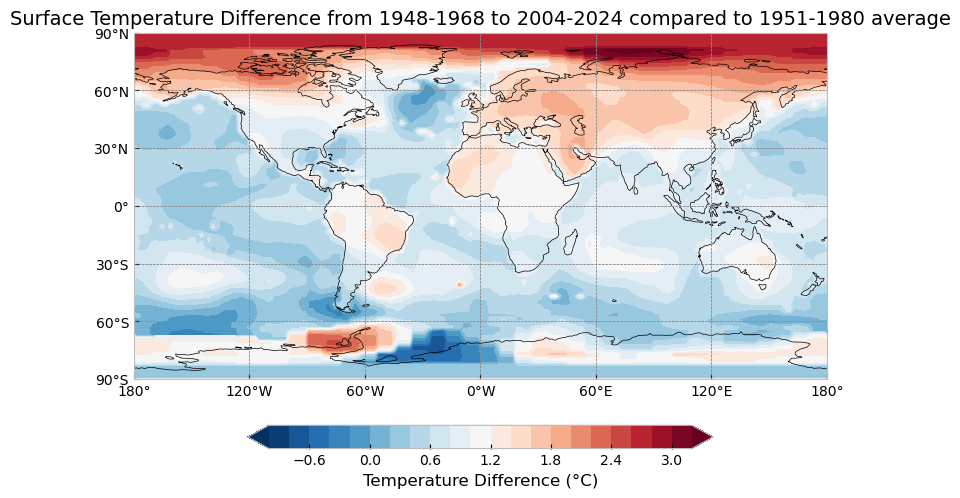

In [35]:
# Task 3.1
ST_diff = np.zeros((len(lat_nasa),len(lon_nasa)))

ST_avg_2004_2024 = np.mean(nasa_regional_mm[(2004-1948)*12+1:,:,:], axis=0)

ST_avg_1948_1968 = np.mean(nasa_regional_mm[0:(1968-1948)*12+1, :, :], axis=0)

ST_diff = ST_avg_2004_2024 - ST_avg_1948_1968

ST_diff_cyclic, longitudes_cyclic = add_cyclic_point(ST_diff, coord=lon_nasa)

#contour_levels = np.arange(-2, 2.1, 0.2) 

fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=cartopy.crs.PlateCarree(central_longitude=0))
ax.set_global()
ax.gridlines(linestyle='--', color='gray')


clevs = np.arange( round(np.min(ST_diff)),round(np.max(ST_diff), 1) , 0.2) 
                  

plt.contourf(longitudes_cyclic, lat_nasa, ST_diff_cyclic, 
             clevs, cmap='RdBu_r', extend='both', 
             transform = cartopy.crs.PlateCarree())


colorbar = plt.colorbar(ax=ax,orientation='horizontal',pad=0.1,aspect=20,shrink=0.5)
colorbar.set_label("Temperature Difference (°C)", size=12, rotation=0)
colorbar.ax.tick_params(labelsize=10)

ax.set_xticks([-180,-120,-60,0, 60, 120, 180], crs=cartopy.crs.PlateCarree())
ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=cartopy.crs.PlateCarree())

lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

ax.coastlines()
plt.title('Surface Temperature Difference from 1948-1968 to 2004-2024 compared to 1951-1980 average', size=14)
plt.show()

**Task 3.2** Now repeat the procedure for Tasks 2.2 and 2.3 (visualization) above, but for a different regression set-up. As before, you are asked to fit a ridge regression to the temperature data, using regional SLP (all grid points, globally) and global CO$_2$ evolution as predictors. Use the period January 2000 to December 2009 as test data, and all other months for training and cross-validation.

However, this time

a) select as predictand time series the temperature evolution (1948 onwards) for **the grid cell that contains the city of Karlsruhe.** For this, you will need to find the corresponding location on the grid on which the NASA temperatures are provided. Note that Karlsruhe is [located](https://latitude.to/map/de/germany/cities/karlsruhe) at approx. 49$\degree$N and 8$\degree$ E. Since the grid resolution for the NASA grid is coarse and the data centred in boxes of 2$\degree\times 2\degree$ spatial resolution, simply select the lat-lon coordinate closest to Karlsruhe so that we will consider temperature changes within a larger area that includes Karlsruhe. If Karlsruhe falls exactly between two coordinates, take the lower index number for simplicity.

b) in addition, instead of MLR, this time fit [LASSO regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) next to ridge regression. As for ridge regression, cross-validate/tune its regularization parameter `alpha`. Add your code to the same cell below!

Make sure you scale the predictors both for ridge and LASSO regression. Set the `random_state` in both regression objects to 222.

Finally, assign the mean squared errors and best $\alpha$ values to the logically named variables.

In [36]:
slp_ka = slp_mm_1948_2024[:,49,8]

coo_ka = co2_mm_1948_2024

nasa_ka = nasa_regional_nc.variables['tempanomaly'][(1948-1880)*12:1736,np.where(lat_nasa == 49)[0],np.where(lon_nasa == 7)[0]]

In [37]:
v = np.column_stack((coo_ka, slp_ka))

mask = np.ones(v.size, dtype=bool)
mask = mask.reshape(v.shape)
mask[(2000-1948)*12:(2009-1948)*12] = False

x_train = v[mask].reshape(812, v.shape[1])
x_test = v[(2000-1948)*12:(2009-1948)*12]

mask = np.ones(nasa_mm_1948_2024.size, dtype=bool)
mask[(2000-1948)*12:(2009-1948)*12] = False

y_train = nasa_ka[mask][:,0,0]
y_test = nasa_ka[(2000-1948)*12:(2009-1948)*12][:,0,0]

In [38]:
print(x_train.shape, y_train.shape, "\n",x_test.shape, y_test.shape)

(812, 2) (812,) 
 (108, 2) (108,)


In [39]:
scaler = StandardScaler()
scaler.fit(x_train)

x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [40]:
mse_ridge_KA = None
best_alpha_ridge_KA = None

# Initial guess
guess = 1
count = 0

for i in np.arange(0,99):
    best_alpha = np.arange(guess/2, guess*3/2, guess/10)

    ridgeKA = RidgeCV(best_alpha, cv = 5)
    ridgeKA.random_state = 222
    
    ridgeKA.fit(x_train_scaled,y_train)
    y_pred = ridgeKA.predict(x_test_scaled)
    if guess == ridgeKA.alpha_:
        count += 1
        if count > 5:
            print("\nConvergence detected. Stopping...\n")
            break
    else:
        count = 0
    
    guess = ridgeKA.alpha_
    print(f"Current alpha: {guess}")

mse_ridge_KA = mean_squared_error(y_test,y_pred)
best_alpha_ridge_KA = guess

print(f"The best mse is {abs(round(mse_ridge_KA,5))} when using {best_alpha_ridge_KA} as alpha.")


Current alpha: 0.5
Current alpha: 0.25
Current alpha: 0.125
Current alpha: 0.0625
Current alpha: 0.03125
Current alpha: 0.015625
Current alpha: 0.0078125
Current alpha: 0.00390625
Current alpha: 0.001953125
Current alpha: 0.0009765625
Current alpha: 0.00048828125
Current alpha: 0.000244140625
Current alpha: 0.0001220703125
Current alpha: 6.103515625e-05
Current alpha: 3.0517578125e-05
Current alpha: 1.52587890625e-05
Current alpha: 7.62939453125e-06
Current alpha: 3.814697265625e-06
Current alpha: 1.9073486328125e-06
Current alpha: 9.5367431640625e-07
Current alpha: 4.76837158203125e-07
Current alpha: 2.384185791015625e-07
Current alpha: 1.1920928955078125e-07
Current alpha: 5.960464477539063e-08
Current alpha: 2.9802322387695312e-08
Current alpha: 1.4901161193847656e-08
Current alpha: 7.450580596923828e-09
Current alpha: 3.725290298461914e-09
Current alpha: 1.862645149230957e-09
Current alpha: 9.313225746154785e-10
Current alpha: 4.656612873077393e-10
Current alpha: 2.3283064365386963

In [41]:
mse_lasso_KA = None
best_alpha_lasso_KA = None

# Initial guess
guess = 0.1
count = 0

for i in np.arange(0,99):
    best_alpha = np.arange(guess/2, guess*3/2, guess/10)

    lassoKA = LassoCV(alphas = best_alpha, cv = 5, max_iter = 1000)
    lassoKA.random_state = 222
    
    lassoKA.fit(x_train_scaled,y_train)
    y_pred = lassoKA.predict(x_test_scaled)
    if guess == lassoKA.alpha_:
        count += 1
        if count > 5:
            print("\nConvergence detected. Stopping...\n")
            break
    else:
        count = 0
    
    guess = lassoKA.alpha_
    print(f"Current alpha: {guess}")

mse_lasso_KA = mean_squared_error(y_test,y_pred)
best_alpha_lasso_KA = guess

print(f"The best mse is {abs(round(mse_lasso_KA,5))} when using {best_alpha_lasso_KA} as alpha.")


Current alpha: 0.05
Current alpha: 0.025
Current alpha: 0.0125
Current alpha: 0.00625
Current alpha: 0.003125
Current alpha: 0.0015625
Current alpha: 0.00078125
Current alpha: 0.000390625
Current alpha: 0.0001953125
Current alpha: 9.765625e-05
Current alpha: 4.8828125e-05
Current alpha: 2.44140625e-05
Current alpha: 1.220703125e-05
Current alpha: 6.103515625e-06
Current alpha: 3.0517578125e-06
Current alpha: 1.52587890625e-06
Current alpha: 7.62939453125e-07
Current alpha: 3.814697265625e-07
Current alpha: 1.9073486328125e-07
Current alpha: 9.5367431640625e-08
Current alpha: 4.76837158203125e-08
Current alpha: 2.384185791015625e-08
Current alpha: 3.576278686523438e-08
Current alpha: 5.006790161132813e-08
Current alpha: 2.5033950805664065e-08
Current alpha: 3.755092620849609e-08
Current alpha: 1.8775463104248044e-08
Current alpha: 2.6285648345947263e-08
Current alpha: 3.9428472518920884e-08
Current alpha: 1.9714236259460442e-08
Current alpha: 2.759993076324462e-08
Current alpha: 3.86399

In [42]:
plotrdg = np.ones(920)
plotrdg[:] = np.nan
plotrdg[(2000-1948)*12:(2009-1948)*12] = ridgeKA.predict(x_test_scaled)

plotlss = np.ones(920)

plotlss[:] = np.nan
plotlss[(2000-1948)*12:(2009-1948)*12] = lassoKA.predict(x_test_scaled)

Text(0.5, 0.98, 'Temperature relative to the 1951 to 1980 average in Karlsruhe')

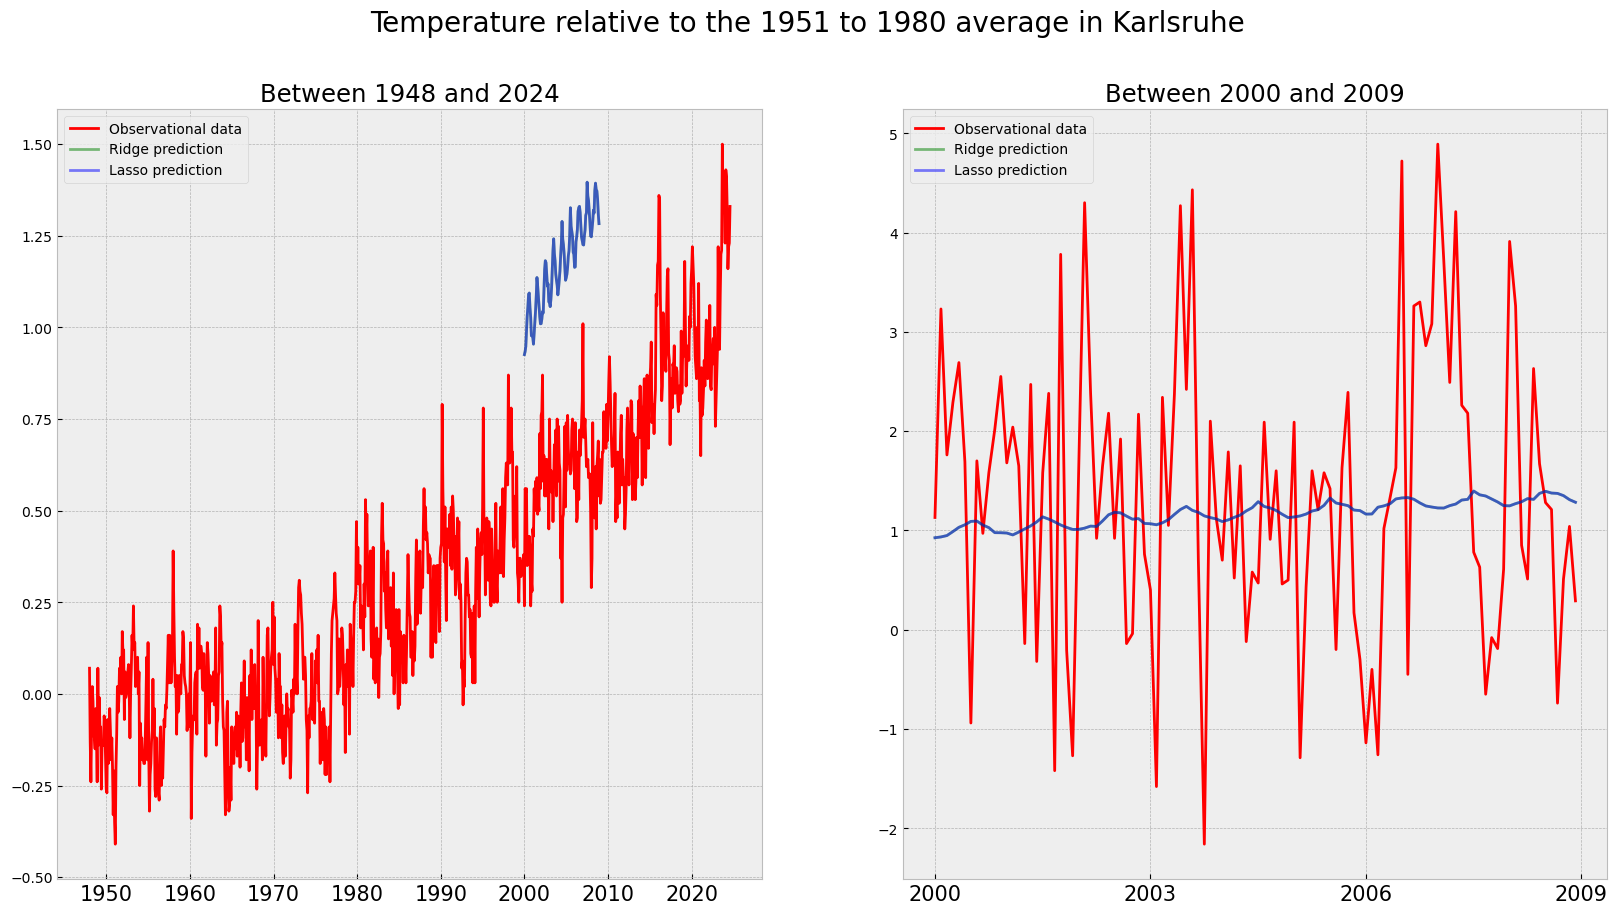

In [43]:
# create visualization of time series, this time for LASSO and Ridge
yrs10 = ['1950', '1960', '1970', '1980', '1990', '2000', '2010', '2020']
yrs3 = ['2000', '2003', '2006', '2009']
fig, ax = plt.subplots(1,2, figsize=(20,10))

ax[0].plot(nasa_mm_1948_2024, color = 'r', label='Observational data')
ax[0].plot(plotrdg, color = 'g', alpha = 0.5, label='Ridge prediction')
ax[0].plot(plotlss, color = 'b', alpha = 0.5, label='Lasso prediction')
ax[0].set_xticks(np.arange(0, 8)*120+24, yrs10, fontsize=15)
ax[0].set_title('Between 1948 and 2024', fontsize=17.5)
ax[0].legend()

ax[1].plot(y_test, color = 'r', label='Observational data')
ax[1].plot(ridgeKA.predict(x_test_scaled), color = 'g', alpha = 0.5, label='Ridge prediction')
ax[1].plot(lassoKA.predict(x_test_scaled), color = 'b', alpha = 0.5, label='Lasso prediction')
ax[1].set_xticks(np.arange(0, 4)* 36, yrs3, fontsize=15)
ax[1].set_title('Between 2000 and 2009', fontsize=17.5)
ax[1].legend()

fig.suptitle('Temperature relative to the 1951 to 1980 average in Karlsruhe', fontsize=20)

**TASK 3.3** Could you suggest ways to improve the performance of machine learning regression models of this kind on test data?

In [44]:
# Task 3.3
answer_improve_predictions = "One way is to tune the other hyperparameters of the models, e.g. tolerance or epsilon. \nIf possible, providing more predictors might also help with improving model accuracy, though due to the curse of dimensionality a need for more observations might arise. Having a predictor with very little variance like co2 and slp might also lead to worse results. The results are worse than those observed in Tasks 2 since we have way less predictors (2 vs. ~10500) \nUsing min-max scaling instead of standard scaling might also improve the result a bit."

print(answer_improve_predictions)

One way is to tune the other hyperparameters of the models, e.g. tolerance or epsilon. 
If possible, providing more predictors might also help with improving model accuracy, though due to the curse of dimensionality a need for more observations might arise. Having a predictor with very little variance like co2 and slp might also lead to worse results. The results are worse than those observed in Tasks 2 since we have way less predictors (2 vs. ~10500) 
Using min-max scaling instead of standard scaling might also improve the result a bit.


**Task 3.4** Finally, let's consider the interpretability of the ridge and LASSO models.

Use `cartopy` to visualize the coefficients of the respective `GridSearchCV().best_estimator_` regression objects using their attribute `.coef_`, but only for the SLP predictors. This means that you need to exclude the coefficient/slope learned for the CO$_2$-related first predictor.

You will then further need to `.reshape()` the dimensions of the resulting coefficient array into a lat-lon matrix of the spatial shape (number latitudes, number longitudes) of the original SLP data. Note that these dimensions are different from the NASA grid for regional temperature.

**Task 3.5** Once you have visualized the coefficients: what is the key difference in the coefficient maps? Can you explain this result?

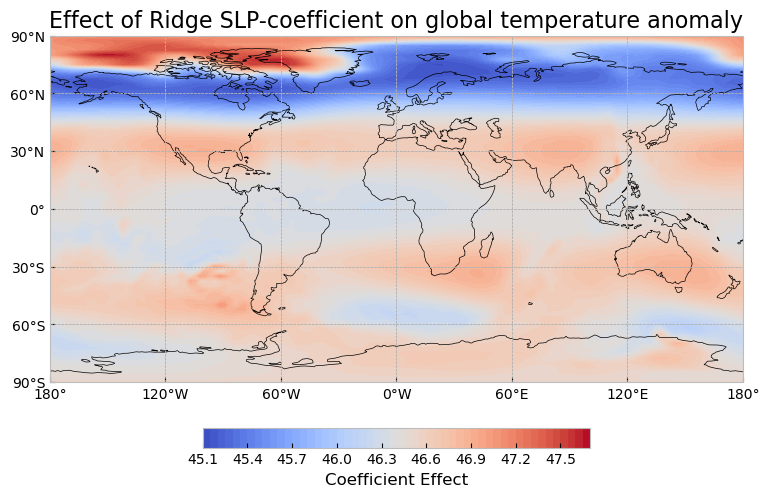

In [45]:
# Task 3.4
slp_coefficient = ridgeKA.coef_[1]

slp_effect = slp_mm_1948_2024.mean(0)[:,:] * slp_coefficient

fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': cartopy.crs.PlateCarree()})
ax.set_title('Effect of Ridge SLP-coefficient on global temperature anomaly', fontsize=16)

contour = ax.contourf(np.linspace(-180, 180, slp_mm_1948_2024.mean(0)[:,:].shape[1]),  # Longitude
                      np.linspace(-90, 90, slp_mm_1948_2024.mean(0)[:,:].shape[0]),  # Latitude
                      slp_effect, 50, cmap='coolwarm', transform=cartopy.crs.PlateCarree())

lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

ax.coastlines()
ax.gridlines()

ax.set_xticks([-180,-120,-60,0, 60, 120, 180], crs=cartopy.crs.PlateCarree())
ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=cartopy.crs.PlateCarree())

colorbar = fig.colorbar(contour, ax=ax, orientation='horizontal', label='', pad=0.1,aspect=20,shrink=0.5)
colorbar.set_label("Coefficient Effect", size=12, rotation=0)
colorbar.ax.tick_params(labelsize=10)

plt.show()


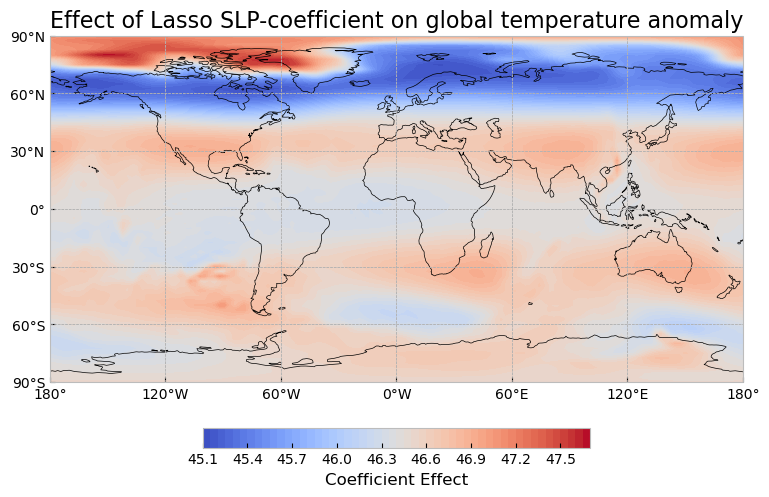

In [46]:
# Task 3.4
slp_coefficient = lassoKA.coef_[1]

slp_effect = slp_mm_1948_2024.mean(0)[:,:] * slp_coefficient

fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': cartopy.crs.PlateCarree()})
ax.set_title('Effect of Lasso SLP-coefficient on global temperature anomaly', fontsize=16)

contour = ax.contourf(np.linspace(-180, 180, slp_mm_1948_2024.mean(0)[:,:].shape[1]),  # Longitude
                      np.linspace(-90, 90, slp_mm_1948_2024.mean(0)[:,:].shape[0]),  # Latitude
                      slp_effect, 50, cmap='coolwarm', transform=cartopy.crs.PlateCarree())

lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

ax.coastlines()
ax.gridlines()

ax.set_xticks([-180,-120,-60,0, 60, 120, 180], crs=cartopy.crs.PlateCarree())
ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=cartopy.crs.PlateCarree())

colorbar = fig.colorbar(contour, ax=ax, orientation='horizontal', label='', pad=0.1,aspect=20,shrink=0.5)
colorbar.set_label("Coefficient Effect", size=12, rotation=0)
colorbar.ax.tick_params(labelsize=10)
plt.show()


In [47]:
# Answer Task 3.5
answer_diff_lasso_ridge = "Due to the predictions being the same, no differences can be observed. What normally should be observable is that the result of Ridge is smoother with more gradual spatial coefficient changes. These should be more abrupt in Lasso."

print(answer_diff_lasso_ridge)

Due to the predictions being the same, no differences can be observed. What normally should be observable is that the result of Ridge is smoother with more gradual spatial coefficient changes. These should be more abrupt in Lasso.


In [48]:
assert len(answer_tuning_alpha_manually) > 0

In [49]:
assert best_alpha_polynomial is not None
assert best_mse_cv_polynomial is not None

In [50]:
assert mse_mlr_global is not None
assert mse_ridge_global is not None
assert best_alpha_global is not None
assert len(answer_scaling) > 0
assert len(answer_curse) > 0

In [51]:
# A few hidden tests on ST_diff

In [52]:
assert mse_ridge_KA is not None
assert mse_lasso_KA is not None
assert best_alpha_ridge_KA is not None
assert best_alpha_lasso_KA is not None
assert len(answer_improve_predictions) > 0

In [53]:
assert len(answer_diff_lasso_ridge) > 0